In [227]:
print("Welcome to Machine Learning!")

Welcome to Machine Learning!


This project requires Python 3.7 or above:

In [228]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [229]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# House values in California

Task is to predict median house values in Californian districts, given a number of features from these districts.

## Downloading Data

In [230]:
from pathlib import Path
import pandas as pd
import pandas_profiling
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing_samples = load_housing_data()

## Descriptive Statistics of the Data

In [231]:
housing_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We can fetch the value counts from the DataFrame.

In [232]:
housing_samples['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

The first 5 samples in the DataFrame

In [233]:
housing_samples.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The last 5 samples in the DataFrame

In [234]:
housing_samples.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


`describe()` give us a good overview of the data.

In [235]:
housing_samples.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Selecting a Performance Measure

As we are working regression the two popular solutions.

RMSE (Root Mean Square Error) as default.

$$
\sqrt{\frac{1}{m} \sum_{i=1}^m\left(h\left(x^{(i)}\right)-y^{(i)}\right)^2}
$$

or if there are many outlier districts. In that case, you may consider using MAE (Mean Absolute Erro).

$$
\frac{1}{m} \sum_{i=1}^m\left|h\left(x^{(i)}\right)-y^{(i)}\right|
$$

# Plotting the Data

In [236]:
import matplotlib.pyplot as plt
%matplotlib inline

Creating a histogram for each feature

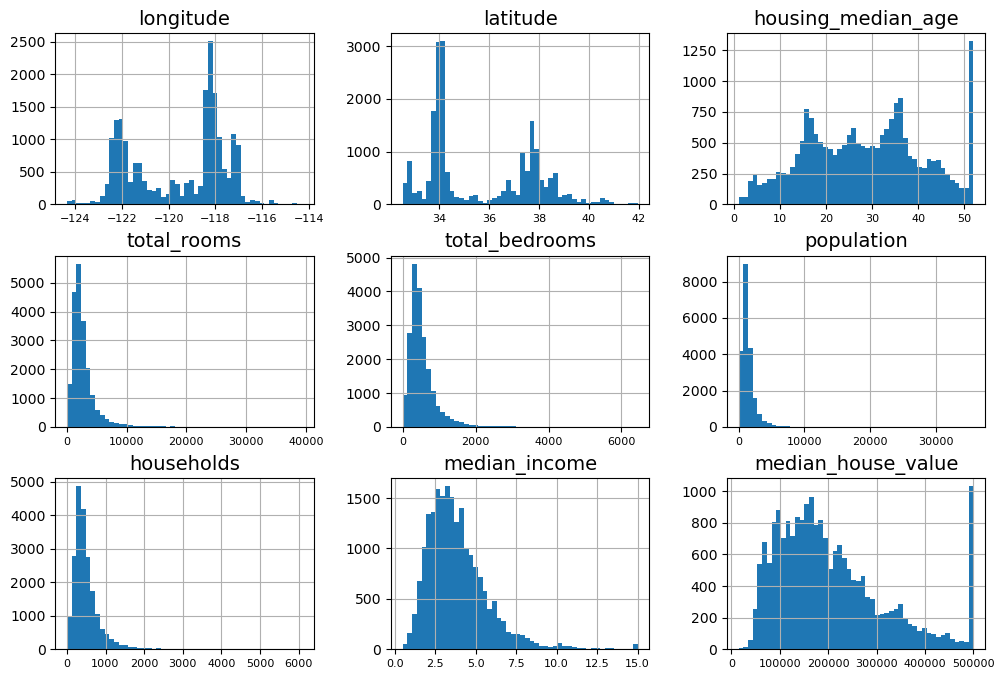

In [237]:
# the histogram have trouble with plotting median_house_value's due to size as it is in houndreds of thousands
# dividing the price with a 1_000 to get shorter number
##housing_samples = housing_samples.rename(columns={'median_house_value':'median_house_value_in_thousands'})

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=10)

housing_samples.hist(bins=50, figsize=(12, 8))
plt.show()


# Creating a Test Set

## Example: Implementing Test devider manually (We usually use train_test_split from sklearn)

`zlib` is a built-in module in Python that provides functions for compression and decompression of data.

`crc32` is a function in the zlib module of Python that calculates the cyclic redundancy check (CRC) checksum of a data stream. The CRC checksum is a type of hash code that is used to detect errors in data transmission or storage.

The `crc32` function takes a bytes-like object as input and returns a 32-bit integer that represents the CRC checksum of the data. 

In [238]:
from zlib import crc32
import numpy as np

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

To make the dataframe compatible with the tests, we need to add an identifier to the datataframe.

In [239]:
housing_samples_with_id = housing_samples.reset_index() # adds an `index` column

# sklearn

To ensure that this notebook's outputs remain the same every time we run it, we need to set the random seed:

In [240]:
np.random.seed(42)

In [241]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_samples, test_size=0.2, random_state=42) #20% of the set is set as a test_set

In [242]:
test_set["total_bedrooms"].isnull().sum()

44

Checking the data sets

In [243]:
train_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16349.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.565121,35.631252,28.592720,2635.515928,538.923420,1428.123123,500.259993,3.863585,206111.152980
std,1.999323,2.133670,12.618367,2142.925654,418.202807,1134.043862,379.273307,1.907402,114790.075691
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.780000,33.940000,18.000000,1454.750000,296.000000,788.000000,280.000000,2.561150,119400.000000
50%,-118.490000,34.250000,29.000000,2129.000000,437.000000,1169.000000,411.000000,3.524600,179200.000000
75%,-118.010000,37.720000,37.000000,3152.250000,648.000000,1726.000000,606.000000,4.727000,263800.000000
max,-114.310000,41.950000,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [244]:
test_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,4128.00000,4128.000000,4128.000000,4128.000000,4084.000000,4128.000000,4128.000000,4128.000000,4128.000000
mean,-119.58804,35.634297,28.826550,2636.751696,533.655730,1414.891231,496.658430,3.899013,209834.472626
std,2.02042,2.145315,12.453216,2330.231265,433.917371,1126.187554,394.352592,1.869154,117753.682098
min,-124.30000,32.560000,2.000000,11.000000,3.000000,8.000000,2.000000,0.499900,14999.000000
25%,-121.83000,33.920000,19.000000,1429.000000,295.000000,781.000000,277.000000,2.578625,121075.000000
50%,-118.51000,34.260000,29.000000,2113.500000,425.000000,1152.000000,403.000000,3.580050,181500.000000
75%,-118.00000,37.710000,37.000000,3123.500000,640.250000,1716.250000,600.000000,4.821875,269900.000000
max,-114.47000,41.820000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100,500001.000000


So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias. When employees at a survey company decides to call 1,000 people to ask them a few questions, they don't just pick 1,000 people randomly in a phone book. They try to ensure that these 1,000 people are representative of the whole population, with regard to the questions they want to ask. For example, the US population is $51.1 \%$ females and $48.9 \%$ males, so a well-conducted survey in the US would try to maintain this ratio in the sample: 511 females and 489 males (at least if it seems possible that the answers may vary across genders).

To find the probability that a random sample of 1,000 people contains less than 48.5% female or more than 53.5% female when the population's female ratio is 51.1%, we use the binomial distribution. The cdf() method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value.

In [251]:
# extra code – shows how to compute the 10.7% probability of getting a bad sample

from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(f'{(proba_too_small + proba_too_large)*100}%')

10.736798530930056%


This is called stratified sampling: the population is divided into homogeneous subgroups called strata, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population. If the people running the survey used purely random sampling, there would be about a $10.7 \%$ chance of sampling a skewed test set with less than $48.5 \%$ female or more than $53.5 \%$ female participants. Either way, the survey results would likely be quite biased.

Suppose you've chatted with some experts who told you that the median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset.

# Income category attribute

Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let’s look at the median income histogram more closely:

Most median income values are clustered around 1.5 to 6 (i.e., $15,000–$60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code uses the pd.cut() function to create an income category attribute with five categories (labeled from 1 to 5); category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on.

In [245]:
housing_samples["income_cat"] = pd.cut(housing_samples["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

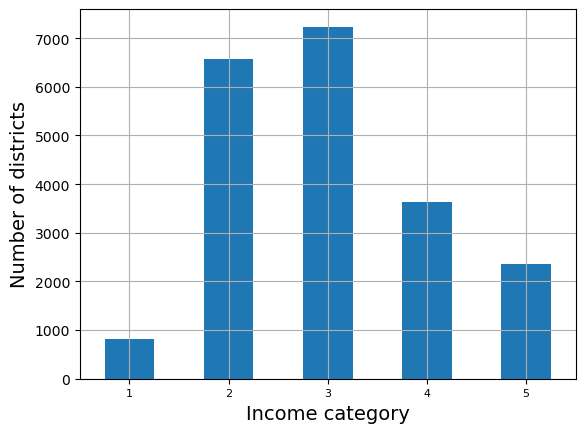

In [246]:
housing_samples["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

### Using the alerts in the report is a good overview for indicators!

For generating a document on the data in the DataFrame.

In [247]:
#report = pandas_profiling.ProfileReport(housing_samples).to_file('housing_report.html')